In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from childes_mi.utils.paths import PHONBANK_DFS, DATA_DIR
from childes_mi.utils.general import flatten

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
phone_df = pd.read_pickle(PHONBANK_DFS/'phone_df.pickle')

In [5]:
phone_df['n_phones'] = [len(list(flatten(i))) for i in phone_df.phones.values]

In [6]:
phone_df[:3]

,name,transcript_id,age,dataset,language,sex,phones,orthography,xml_loc,n_phones
0,0,020926,2.833,Providence,eng,male,"[[ˈhi, ˈhæ, rəs], [ˈhi, ˈhæ, rəs], [ˈkævəʔ, ˈp...","[[[can, I], have, this], [[can, I], have, this...",/mnt/cube/tsainbur/Projects/github_repos/child...,1772
0,0,030006,3.000,Providence,eng,male,"[[*, haʊ, ˈbaʊ, *, ɪ, ˈdeɪ, mætʃ], [deɪ, ˈmætʃ...","[[xxx, how, <a>bout, xxx, if, they, match], [t...",/mnt/cube/tsainbur/Projects/github_repos/child...,2277
0,0,011117,2.000,Providence,eng,male,"[[None], [None], [None], [hɪ, ˈmi], [ˈbu], [No...","[[xxx], [xxx], [xxx], [help, me], [bowl], [xxx...",/mnt/cube/tsainbur/Projects/github_repos/child...,561


In [7]:
phone_df.dataset.unique()

array(['Providence', 'Davis', 'Goad'], dtype=object)

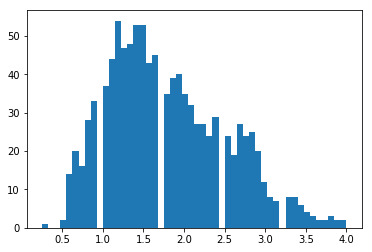

In [8]:
plt.hist(phone_df.age.values, bins = 50);

In [9]:
print("There are {} phones in this dataset".format(np.sum(phone_df.n_phones)))

There are 618583 phones in this dataset


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


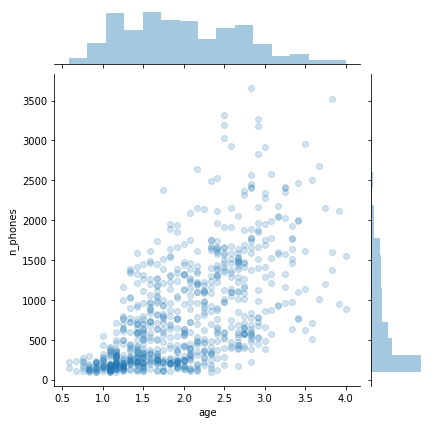

In [10]:
import seaborn as sns
sns.jointplot("age", "n_phones", data=phone_df[phone_df.n_phones > 100], alpha=0.2)

In [11]:
np.median(phone_df.n_phones)

306.0

## MI
- for each sequence, calculate the decay of a sequence as a function of distance between elements for that sequence indiividually
- Treat each phoneme as unique for that child, and compute MI across children

In [12]:
from childes_mi.information_theory import mutual_information as mi

#### Test run

In [17]:
age_cohorts = [[0.5, 1], [1, 1.5], [1.5, 2], [2, 2.5], [2.5, 3], [3, 20]]

In [18]:
distances = np.arange(1,101)

In [36]:
longest_row.age

name                                                             0
transcript_id                                               030214
age                                                          3.167
dataset                                                 Providence
language                                                       eng
sex                                                           male
phones           [[None], [ˈlok], [ˈjɛs], [mə, ˈhi], [ˈmʌɪ, ˈwʌ...
orthography      [[xxx], [look], [yes], [my, piece], [Mommy, wa...
xml_loc          /mnt/cube/tsainbur/Projects/github_repos/child...
n_phones                                                      1606
Name: 0, dtype: object

In [43]:
nex = 25
MI_DF_long = pd.DataFrame(
    columns=[
        "MI",
        "MI_var",
        "shuff_MI",
        "shuff_MI_var",
        "distances",
        "age_cohort_low",
        "age_cohort_high",
        "n_phones",
        "n_unique_phones",
        "age",
        "dataset",
        "xml_loc",
        "n_phones",  
        "phones_list"
        
    ]
)
# for each age cohort
for (age_cohort_low, age_cohort_high) in tqdm(age_cohorts):
    cohort_subset = phone_df[
        (phone_df.age > age_cohort_low) & (phone_df.age <= age_cohort_high)
    ]
    
    for idx, longest_row in tqdm(cohort_subset.sort_values(by='n_phones', ascending=False)[:nex].iterrows(), total=nex):
        phones_list = ''.join(flatten([i for i in flatten(longest_row.phones) if i is not None]))
        (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information([list(phones_list)], 
                                                                                  distances = distances)
        
        n_phones = len(phones_list)
        n_unique_phones = len(np.unique(phones_list))
        
        MI_DF_long.loc[len(MI_DF_long)] = [
            MI,
            MI_var,
            shuff_MI,
            shuff_MI_var,
            distances,
            age_cohort_low,
            age_cohort_high,
            n_phones,
            n_unique_phones,
            longest_row.age,
            longest_row.dataset,
            longest_row.xml_loc,
            longest_row.n_phones,
            phones_list
            
        ]

In [38]:
MI_DF_long[:3]

,MI,MI_var,shuff_MI,shuff_MI_var,distances,age_cohort_low,age_cohort_high,n_phones,n_unique_phones,age,dataset,xml_loc,n_phones
0,"[4.499999713000699, 4.206104073935023, 3.99378...","[0.06032328910968175, 0.05988537201573046, 0.0...","[3.5901735922547147, 3.5819451114882206, 3.570...","[0.058410382250742486, 0.05819692804503222, 0....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.5,1,2643,1,1.0,Providence,/mnt/cube/tsainbur/Projects/github_repos/child...,543
1,"[4.318715239977827, 3.967898421331192, 3.80850...","[0.05641612006563012, 0.05543521532093411, 0.0...","[3.5330860559197177, 3.5257304119161876, 3.536...","[0.05500876139807492, 0.055044009479310464, 0....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.5,1,2280,1,1.0,Providence,/mnt/cube/tsainbur/Projects/github_repos/child...,434
2,"[3.2802134582860445, 3.11281825431207, 3.07556...","[0.10935063266969271, 0.10873530496867546, 0.1...","[3.023800427619456, 3.032835689422397, 3.00731...","[0.10847919033056949, 0.10891932142233333, 0.1...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.5,1,627,1,1.0,Davis,/mnt/cube/tsainbur/Projects/github_repos/child...,325


0.5 1


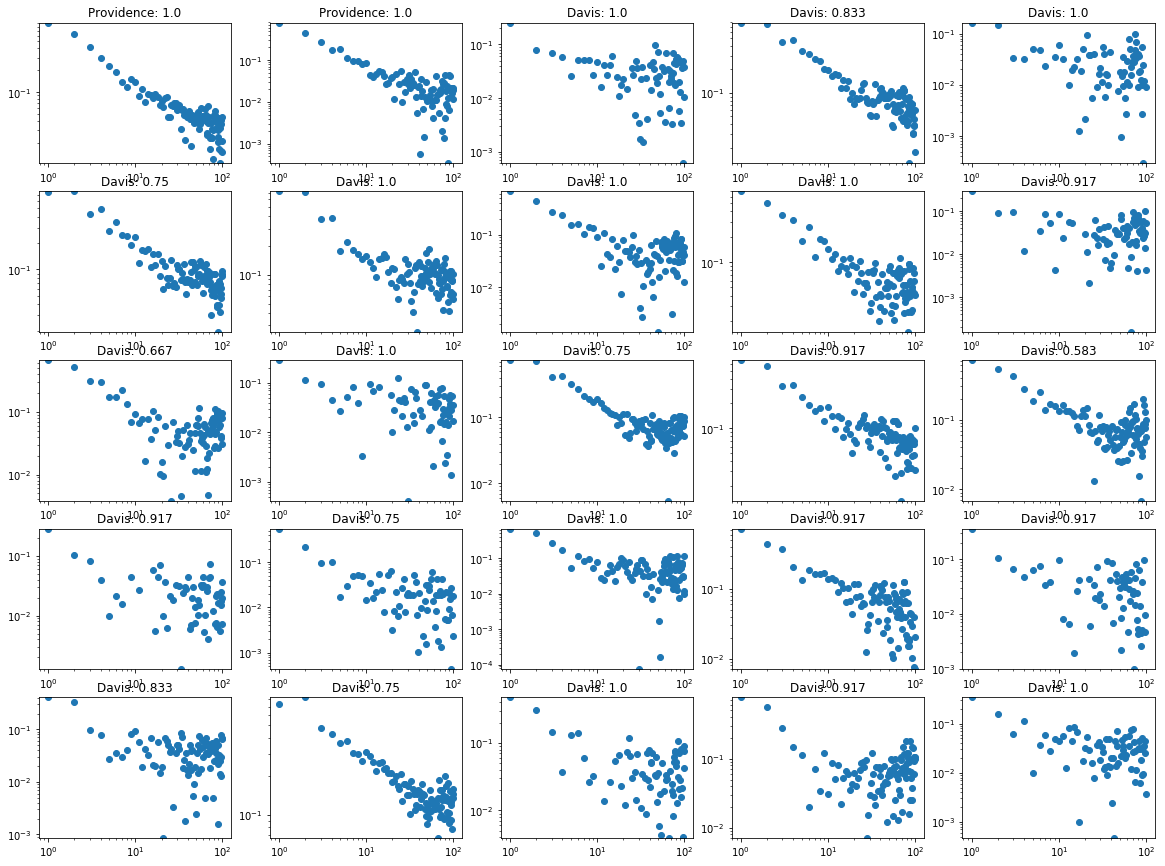

1 1.5


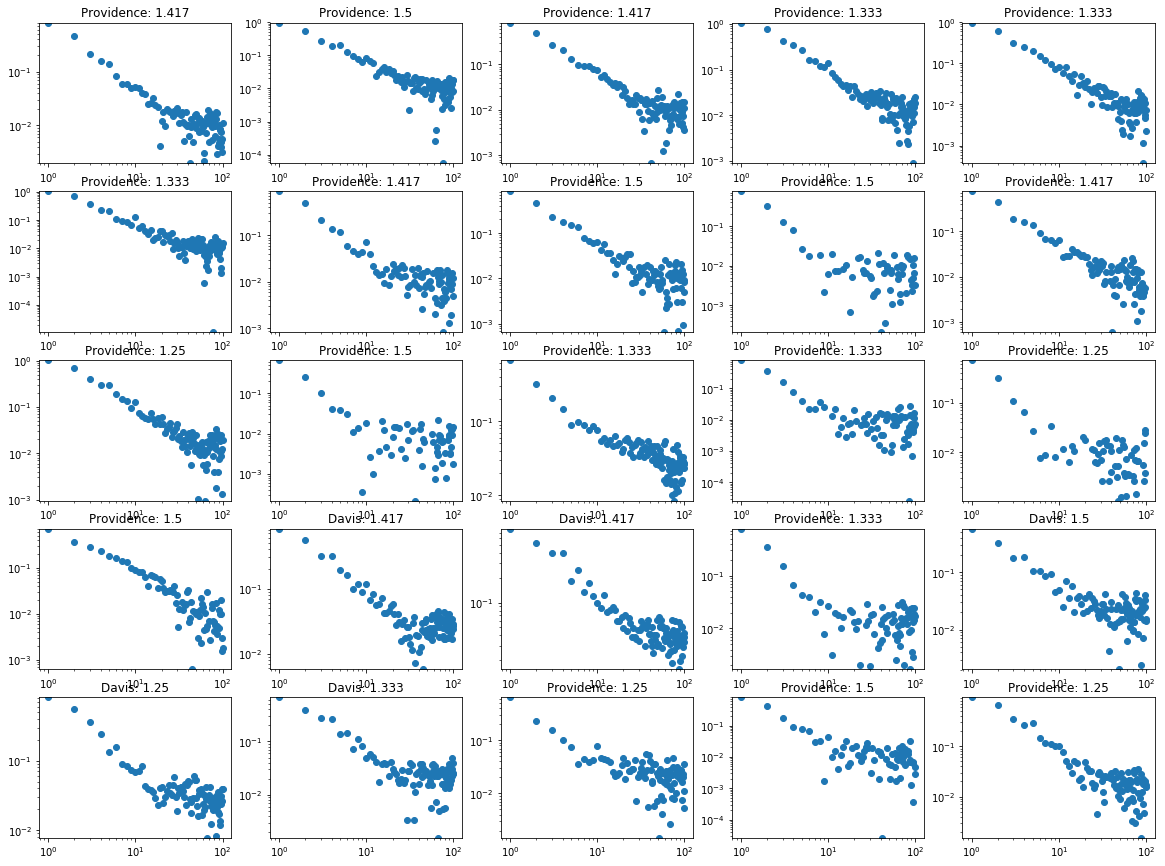

1.5 2


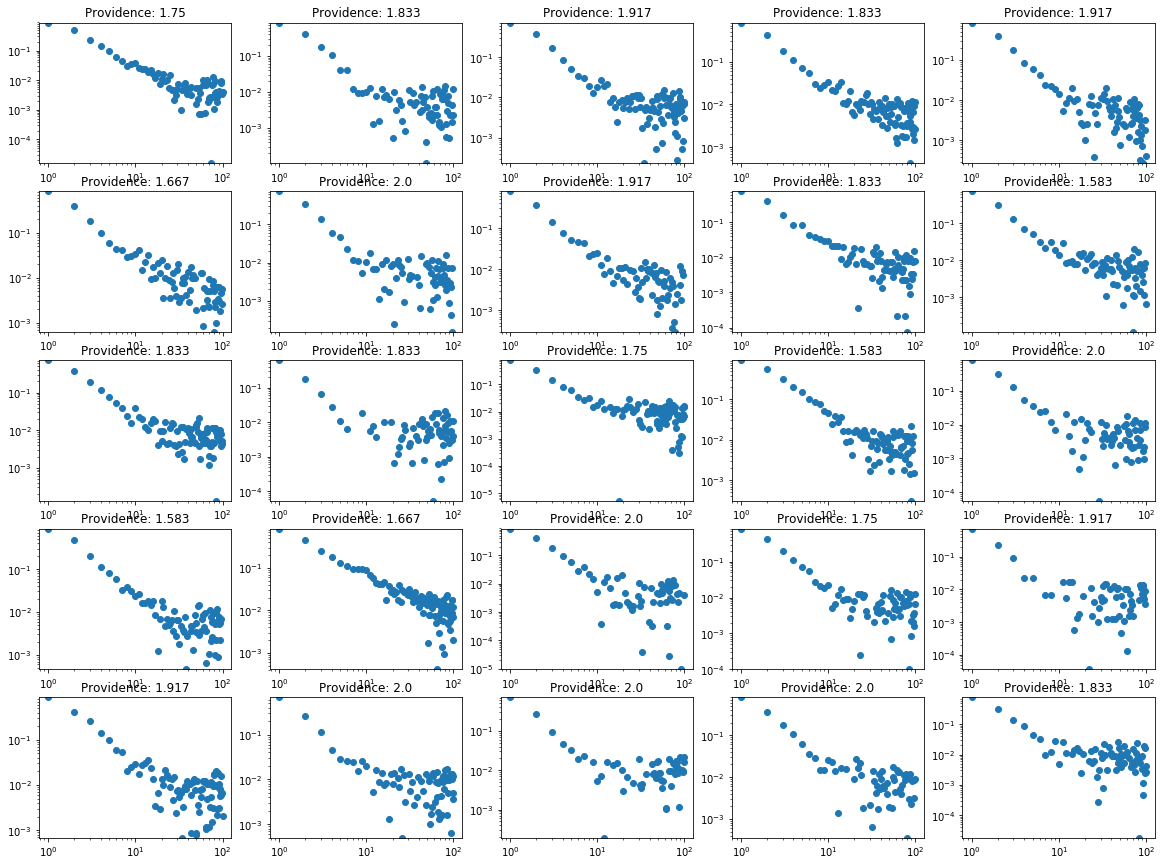

2 2.5


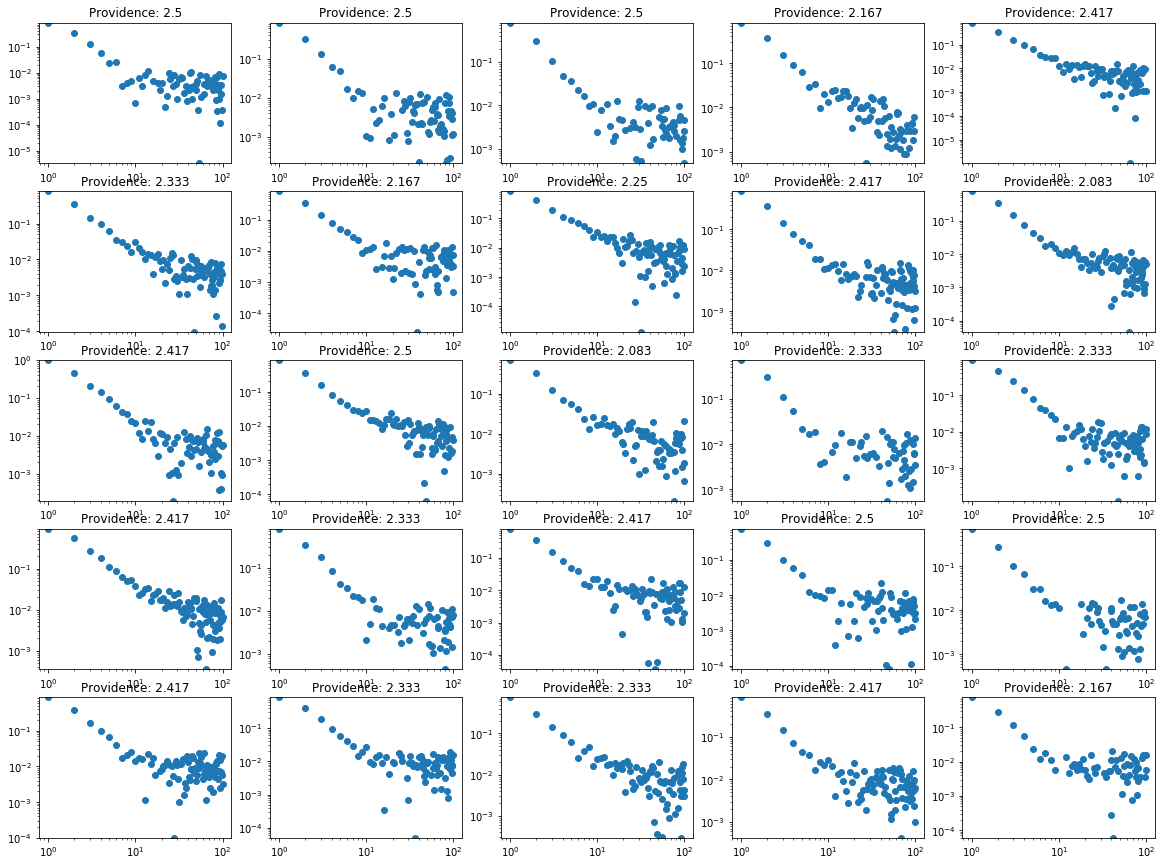

2.5 3


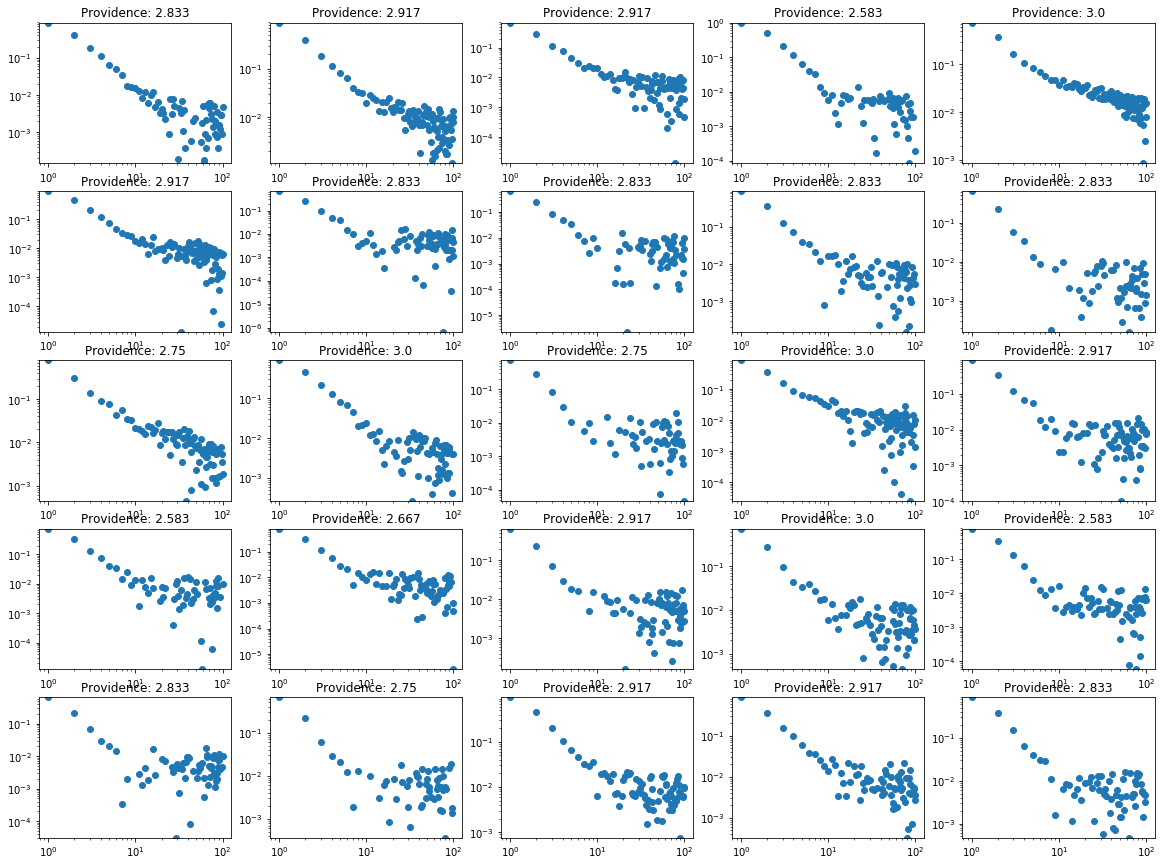

3 20


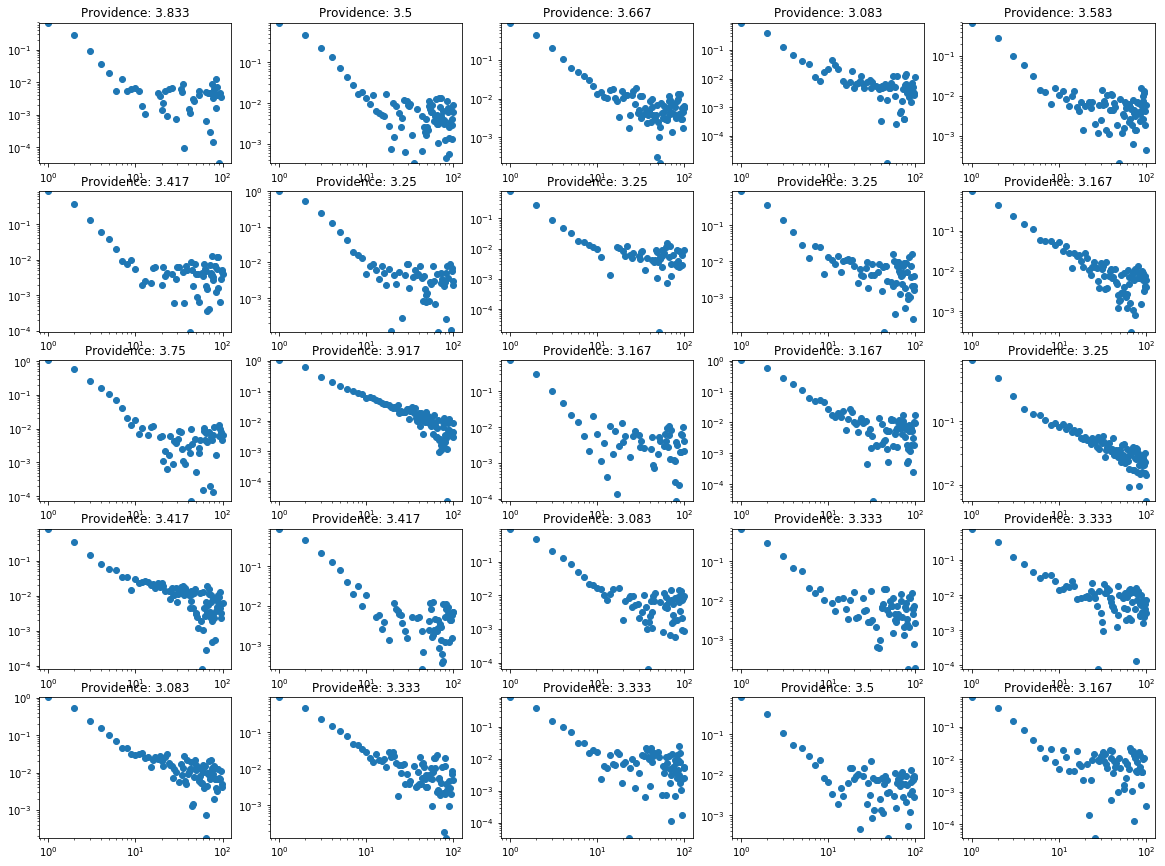

In [40]:
for (age_cohort_low, age_cohort_high) in tqdm(age_cohorts):
    cohort_subset = MI_DF_long[MI_DF_long.age_cohort_high == age_cohort_high]
    print(age_cohort_low, age_cohort_high)
    fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20,15))
    for idxi, (idx, row) in tqdm(enumerate(cohort_subset.iterrows())):
        
        MI = row.MI
        shuff_MI = row.shuff_MI
        
        ax = axs.flatten()[idxi]
        ax.scatter(distances, MI-shuff_MI)
        ax.plot(distances, MI-shuff_MI, alpha = 0)
        
        axmin = np.min((MI-shuff_MI)[(MI-shuff_MI) > 0])
        axmax = np.max((MI-shuff_MI)[(MI-shuff_MI) > 0])
        ax.set_title("{}: {} | {}".format(row.dataset, row.agerow.n_phones))
        ax.set_ylim([axmin, axmax])
        ax.set_yscale('log')
        ax.set_xscale('log')
    plt.show()

In [41]:
phones_list

'ˈlokˈjɛsməˈhiˈmʌɪˈwʌˈpleɪˈlʌɡizɑbˈdɛə*ˈwɪlɪˈɡɜ˞roməˈlɛsɡoəlɪˈfɑːmˈjɛsˈtʃɪkɛnðəˈwɛnnoˈwirɑˈoˈtæsɪˈtwædʊˈsijəˈweɪɡə*ˈmɛhəˈbɑˈjuɡonəˈɡwæsɛnfaʊˈwʌdəˈtʃikɛnˈɡɔɪndəˈnʌ*nɑˈnɑnɑˈnɑhiɪsənəˈpiˈnoˈklosiˈdoə*əˈnʌmədisˈnopˈnoːˈiːˈeɪɾɪˈkɛˈwoˈhuwəsˈdætˈnʌɪnonoˈdʒoinoˈdɔɪnoˈdoilʊkʊˈkʌɑˈpeɪˈwɪlɪˈkɪliəˈmaɪmaɪeɪˈtʌn*ˈtaɪfʊˈwʌˈwisˈwʌɪaɪˈseɪɡoˈnaɪnaɪˈtaɪmduˈɡoɾəwəkˈnaʊəˈwʌwaɪˈwɑtʃˈmomaɪmaɪˈwɑtʃˈtaɪmuˈɡoləˈwʌˈwɛɪˈbæəˈɛjɪˈbosˈfɛjɪbɑˈlooˈkeɪˈdɪsɪsˈɡostɪnəˈuːˈɪliˈʔɛfʌt*ˈpʊɪwaɪˈhiəhəwəhɪ*ˈɪwʊˈheɪəˈbɪtwimaɪfwiˈɡaɪswəsˈdæəˈlaɪˈfɛtəbəlˈulɛsˈfaɪˈvɛtəbəlˈmʌmˈlʊkɪˈzɛləfɪlʊkɪˈmiˈmʌˈmɑmiˈɛnɪˈɡaɪsˈɡeɪwəlɪˈfɪsɪbosˈjɛsˈmaʊˈmʌmkəmˈiʰˈbuoˈdɪsɡos*ˈovəˈhɛənəˈfɛnsˈmʌmˈmʌmuˈmɑmˈmɑmlʊɡɪə*ˈɡwəsɪnˈhiəməˈhaʊwəˈbaʊs*ˈɡwiɡosəəˈtwiˈʌp(.)ˈtaʊnˈʌpˈaʊnˈʌpˈaʊnˈʌpˈdaʊnˈʌpˈdaʊnˈʌpˈdaʊnˈʌpˈʌpˈdaʊnˈʌpˈlijuˈhosɪsˈlʊfoˈdaʊɪn*iˈjɛsˈmɑːmwəˈwoməˈmiˈplisˈplisɪˈjuˈsinəðəˈlʊkˈɪwəsˈhirðəˈfɑmˈmʌˈbudəˈjusi*tswaɪˈɪwəˈmɑˈlɛsduləˈhɛəəˈmoˈfʌsiɡos(.)ˈowɪˈhiəlɪɾəˈbɪˈlɪləˈbeɪbiˈwɛsdəˈoðɪsˈpleɪsɪzəˈfɑmɪtɪsˈɡosɪˈnɛdiˈkaʊˈpisəˈfɛˈwo(.)ðæsˈhaɪˈuː*ˈfaɪnɪ*ˈoəˈbaʊts